In [78]:
from os import rename

import pandas as pd
import numpy as np
import warnings

pd.options.display.max_columns = None
warnings.filterwarnings("ignore")

from google.cloud import bigquery
from google.cloud import bigquery_storage
creds = "/Users/srdeo/OneDrive - Copart, Inc/secrets/cprtpr-datastewards-sp1-614d7e297848 (1).json"
client = bigquery.Client.from_service_account_json(json_credentials_path=creds)
bqstorageclient = bigquery_storage.BigQueryReadClient(credentials=creds)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Q1. Total number of Premier members in Copart?

In [141]:
query1 = """
select mbr_nbr, owner_mbr_nbr, mbr_country_desc, mbr_mbrshp_type_cd, mbr_status
from `cprtpr-dataplatform-sp1`.usviews.v_us_member_fact
"""

data_members_2025 = client.query(query1).to_dataframe()

In [142]:
data_members_2025.head()
data_members_2025.shape
print(data_members_2025.isnull().sum())
data_members_2025['mbr_mbrshp_type_cd'].value_counts()

,mbr_nbr,owner_mbr_nbr,mbr_country_desc,mbr_mbrshp_type_cd,mbr_status
0,1241569915757772800,1241569915757772800,None,GUEST,None
1,1240848294738911232,1240848294738911232,None,GUEST,None
2,464285,464285,UNITED STATES,GUEST,I
3,1241385582340190208,1241385582340190208,None,GUEST,None
4,1240839219760304128,1240839219760304128,None,GUEST,None


(12560431, 5)

mbr_nbr                      0
owner_mbr_nbr                0
mbr_country_desc       9958820
mbr_mbrshp_type_cd           0
mbr_status            11663855
dtype: int64


mbr_mbrshp_type_cd
GUEST      11722393
BASIC        691271
PREMIER      146767
Name: count, dtype: int64

In [9]:
## Total number of duplicate owner numbers

data_members_2025.duplicated('owner_mbr_nbr').sum()

np.int64(47399)

In [13]:
## Dropping duplicates based on owner_mbr_nbr

data_members_2025_no_duplicates = data_members_2025.drop_duplicates('owner_mbr_nbr')

In [14]:
data_members_2025_no_duplicates['mbr_mbrshp_type_cd'].value_counts()

mbr_mbrshp_type_cd
GUEST      11687683
BASIC        691407
PREMIER      102100
Name: count, dtype: int64

In [19]:
counts = data_members_2025_no_duplicates['mbr_mbrshp_type_cd'].value_counts()
percentages = data_members_2025_no_duplicates['mbr_mbrshp_type_cd'].value_counts(normalize=True) * 100

summary = pd.DataFrame({
    'Count': counts,
    'Percentage': percentages.round(2)
})

summary

,Count,Percentage
mbr_mbrshp_type_cd,,
GUEST,11687683,93.64
BASIC,691407,5.54
PREMIER,102100,0.82


In [17]:
## To check null values in the dataset

data_members_2025_no_duplicates.isnull().sum()

mbr_nbr                      0
owner_mbr_nbr                0
mbr_country_desc       9929716
mbr_mbrshp_type_cd           0
mbr_status            11634936
dtype: int64

In [18]:
data_members_2025_no_duplicates.shape

(12481190, 5)

### Q2. How many Premier members have bought lots in the last 6 months/ 3 months/ 1 month?

In [143]:
query4 = """
select member_sgmnt_type, count(*) as member_count
from `cprtpr-dataplatform-sp1`.usviews.v_us_member_fact
where mbr_mbrshp_type_cd = 'PREMIER'
group by member_sgmnt_type
"""

data_PM_type = client.query(query4).to_dataframe()

In [144]:
data_PM_type.head()
data_PM_type.shape
print(data_PM_type.isnull().sum())

,member_sgmnt_type,member_count
0,None,5574
1,Dismantler,28850
2,General Business,3728
3,Dealer,33687
4,Consumer,45582


(6, 2)

member_sgmnt_type    1
member_count         0
dtype: int64


In [23]:
## Check duplicates in owner_mbr_nbr

data_premier_buying_6months['owner_mbr_nbr'].duplicated().sum()

np.int64(1785707)

In [24]:
data_premier_buying_6months = data_premier_buying_6months.drop_duplicates(['owner_mbr_nbr'])

In [25]:
data_premier_buying_6months['mbr_nbr'].nunique()

55263

In [26]:
## Extracting month from the invoice date

data_premier_buying_6months['inv_dt'] = pd.to_datetime(data_premier_buying_6months['inv_dt'])
data_premier_buying_6months['inv_dt_month'] = data_premier_buying_6months['inv_dt'].dt.month

data_premier_buying_6months

,lot_nbr,buyer_nbr,mbr_nbr,owner_mbr_nbr,mbr_status,mbr_country_desc,inv_dt,acv,high_bid_amt,inv_dt_month
0,45928735,248618,248618,248618,A,UNITED STATES,2025-02-23,0.00,10500.0,2
1,80509744,6915,6915,6915,A,UNITED STATES,2025-01-26,0.00,550.0,1
2,53283265,31666,31666,31666,A,"GHANA,REPUBLIC OF",2025-05-24,24922.00,5700.0,5
3,59498104,129396,129396,484427,I,UNITED ARAB EMIRATES,2024-12-29,22440.00,4200.0,12
4,69954044,495671,495671,495671,A,MAURITANIA,2024-12-07,20450.40,5500.0,12
...,...,...,...,...,...,...,...,...,...,...
1840703,53085165,137291,137291,137291,I,UNITED STATES,2025-06-10,25884.89,14900.0,6
1840854,45089285,147562,147562,147562,A,UNITED STATES,2025-06-10,9732.00,3250.0,6
1840858,42251735,486977,486977,486977,A,UNITED STATES,2025-06-10,2665.00,1750.0,6
1840862,58442385,746062,746062,746062,A,CANADA,2025-06-10,25319.14,16200.0,6


In [27]:
## Dividing the data into different month groups

data_premier_buying_6months_Dec_to_May = data_premier_buying_6months[data_premier_buying_6months['inv_dt_month'].isin([12, 1, 2, 3, 4, 5])]
data_premier_buying_6months_May = data_premier_buying_6months[data_premier_buying_6months['inv_dt_month'] == 5]
data_premier_buying_6months_March_to_May = data_premier_buying_6months[data_premier_buying_6months['inv_dt_month'].isin([3, 4, 5])]

In [29]:
data_premier_buying_6months_Dec_to_May['owner_mbr_nbr'].nunique()

52848

In [30]:
data_premier_buying_6months_March_to_May['owner_mbr_nbr'].nunique()

16817

In [31]:
data_premier_buying_6months_May['owner_mbr_nbr'].nunique()

5031

### Q3. What is the distribution of ACV and Selling Price for lots bought by Premier members in the last 6 months?

<Axes: title={'center': 'ACV Distribution'}, ylabel='Frequency'>

(np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(1.0))

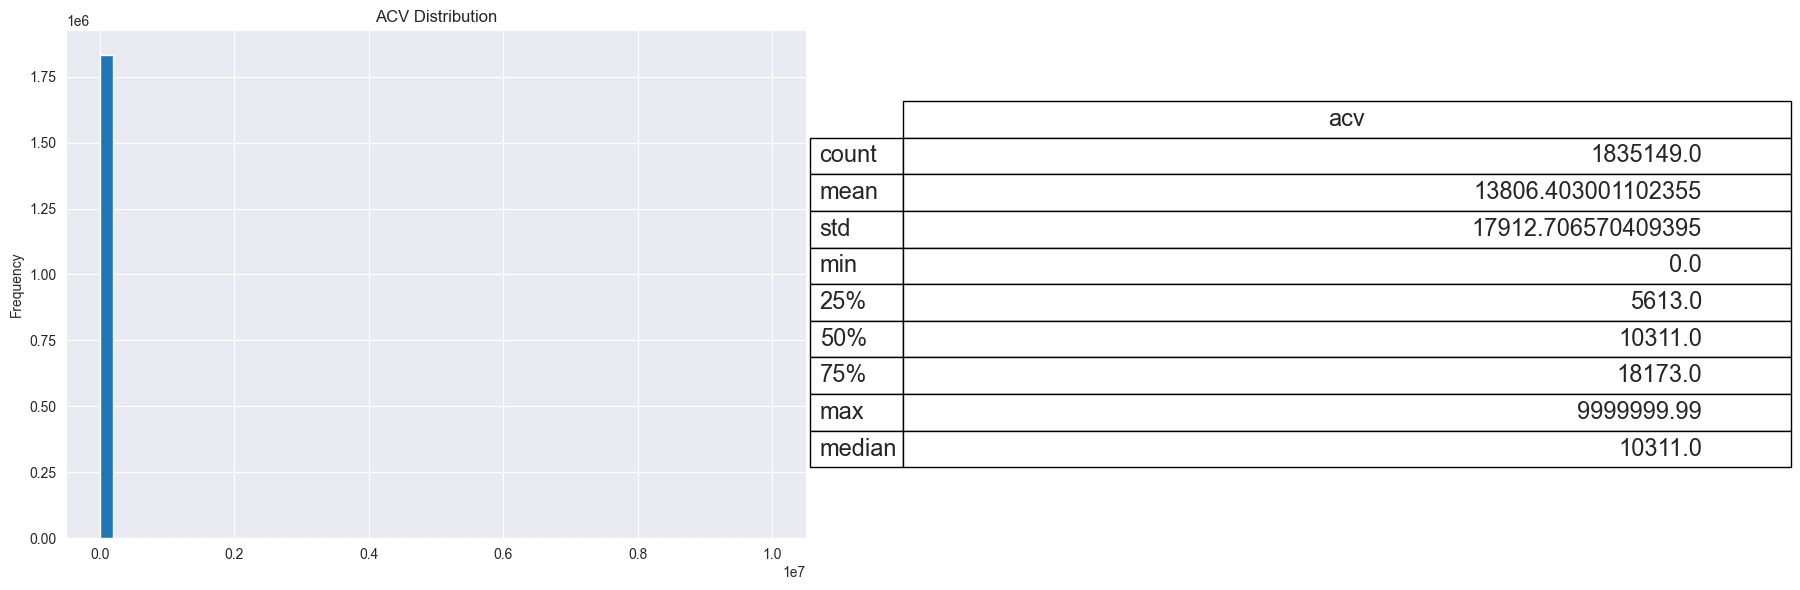

In [129]:
## ACV Distribution and Outliers

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Histogram
data_premier_buying_6months['acv'].plot(
    kind='hist', bins=50, ax=axes[0], title='ACV Distribution'
)

# Describe table
desc = data_premier_buying_6months['acv'].describe().to_frame()
desc.loc['median'] = data_premier_buying_6months['acv'].median()
axes[1].axis('off')
table = axes[1].table(
    cellText=desc.values,
    rowLabels=desc.index,
    colLabels=['acv'],
    loc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(17)
table.scale(1.2,2)

plt.tight_layout()
plt.show()

#### * Checking for outliers in ACV

In [130]:
data_premier_buying_6months[data_premier_buying_6months['acv']==0]

,lot_nbr,buyer_nbr,mbr_nbr,owner_mbr_nbr,mbr_country_desc,mbr_status,inv_dt,acv,high_bid_amt,inv_dt_month
9,53718995,909921,909921,909921,UNITED STATES,A,2025-05-26,0.0,1600.0,5
14,80587454,244151,244151,220834,UNITED STATES,A,2024-12-14,0.0,104000.0,12
15,47804385,339109,339109,339109,UNITED STATES,A,2025-04-12,0.0,500.0,4
16,41569545,383732,383732,383732,UNITED STATES,A,2025-05-11,0.0,500.0,5
33,51361905,524325,524325,524325,UNITED STATES,A,2025-04-20,0.0,300.0,4
...,...,...,...,...,...,...,...,...,...,...
1835094,50359625,420688,420688,420688,UNITED STATES,A,2025-06-10,0.0,7500.0,6
1835102,58924975,200283,200283,200283,UNITED ARAB EMIRATES,A,2025-06-10,0.0,500.0,6
1835128,59606095,895668,895668,688783,UNITED STATES,A,2025-06-10,0.0,700.0,6
1835129,54176125,519058,519058,519058,UNITED STATES,A,2025-06-10,0.0,1050.0,6


In [131]:
data_premier_buying_6months[data_premier_buying_6months['acv']==9999999.99]

,lot_nbr,buyer_nbr,mbr_nbr,owner_mbr_nbr,mbr_country_desc,mbr_status,inv_dt,acv,high_bid_amt,inv_dt_month
1678425,57888305,583968,583968,583968,UNITED STATES,A,2025-05-22,9999999.99,10900.0,5
1759674,56763685,8917,8917,8917,UNITED STATES,A,2025-06-02,9999999.99,1600.0,6


<Axes: title={'center': 'Selling Price Distribution'}, ylabel='Frequency'>

(np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(1.0))

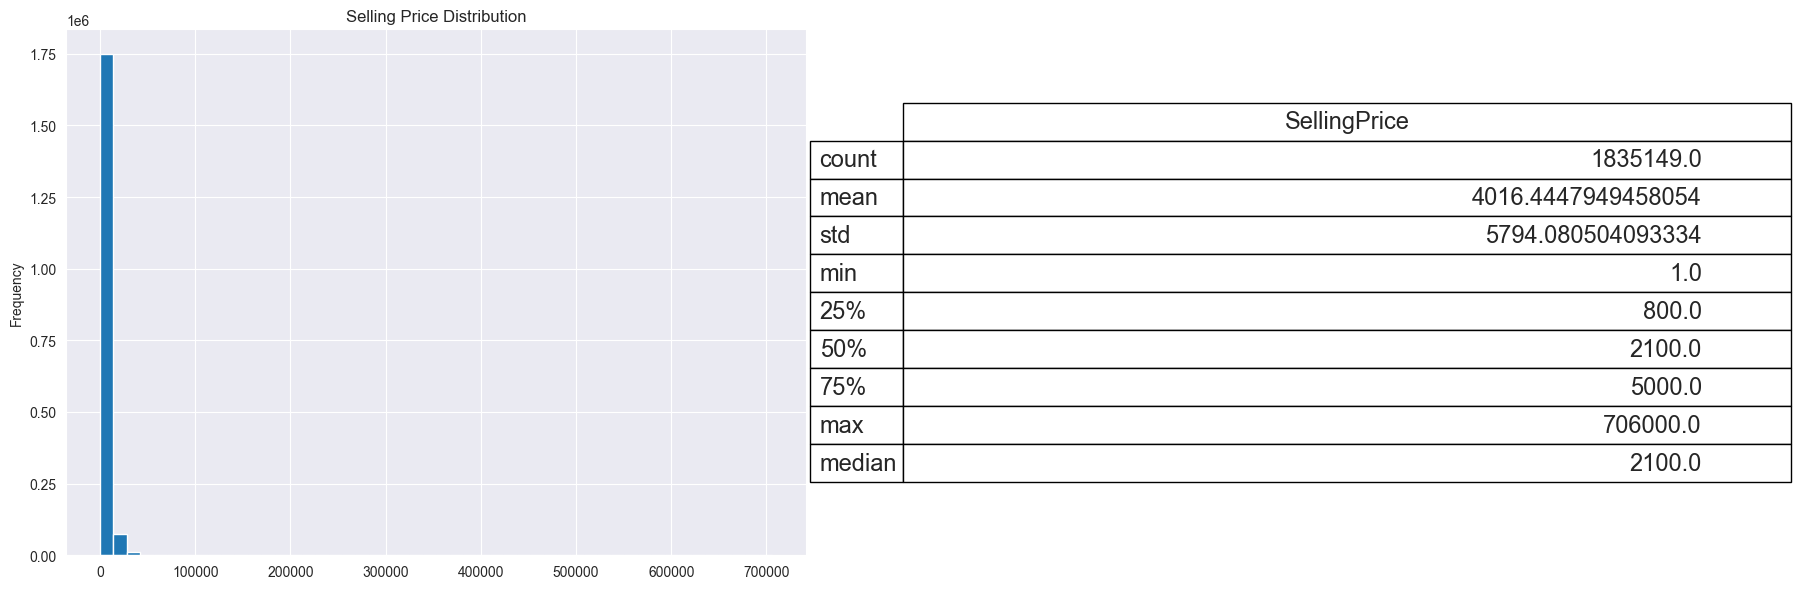

In [132]:
## Selling Price Distribution and Outliers

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Histogram
data_premier_buying_6months['high_bid_amt'].plot(
    kind='hist', bins=50, ax=axes[0], title='Selling Price Distribution'
)

# Describe table
desc = data_premier_buying_6months['high_bid_amt'].describe().to_frame()
desc.loc['median'] = data_premier_buying_6months['high_bid_amt'].median()
axes[1].axis('off')
table = axes[1].table(
    cellText=desc.values,
    rowLabels=desc.index,
    colLabels=['SellingPrice'],
    loc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(17)
table.scale(1.2,2)

plt.tight_layout()
plt.show()

#### * Checking for outliers in Selling Price

In [133]:
data_premier_buying_6months[data_premier_buying_6months['high_bid_amt']==706000]

,lot_nbr,buyer_nbr,mbr_nbr,owner_mbr_nbr,mbr_country_desc,mbr_status,inv_dt,acv,high_bid_amt,inv_dt_month
823676,79169614,580261,580261,580261,UNITED STATES,A,2025-02-24,1624907.0,706000.0,2


In [134]:
data_premier_buying_6months[data_premier_buying_6months['high_bid_amt']==1]

,lot_nbr,buyer_nbr,mbr_nbr,owner_mbr_nbr,mbr_country_desc,mbr_status,inv_dt,acv,high_bid_amt,inv_dt_month
34296,75170834,110743,110743,110743,UNITED STATES,A,2024-12-02,7841.00,1.0,12
37938,72533774,110743,110743,110743,UNITED STATES,A,2024-12-02,29815.00,1.0,12
39174,77695244,110743,110743,110743,UNITED STATES,A,2024-12-02,25415.00,1.0,12
45560,63278724,110743,110743,110743,UNITED STATES,A,2024-12-03,21801.00,1.0,12
66308,73007674,49996,49996,49996,UNITED STATES,A,2024-12-04,12859.00,1.0,12
...,...,...,...,...,...,...,...,...,...,...
1810687,42826995,49996,49996,49996,UNITED STATES,A,2025-06-09,9946.00,1.0,6
1813113,51479655,69595,69595,69595,UNITED STATES,A,2025-06-09,24650.00,1.0,6
1820213,56182192,303188,303188,303188,UNITED STATES,A,2025-06-09,1.00,1.0,6
1821496,52606475,69595,69595,69595,UNITED STATES,A,2025-06-09,8983.00,1.0,6


### Q4. Total number of unique PMs who placed a bid (on the lots sold) in the last month, last 3 months and last 6 months

In [3]:
query3 = """
select b.owner_mbr_nbr, a.buyer_nbr, a.lot_nbr, c.inv_dt
from `cprtpr-dataplatform-sp1`.usviews.v_us_bids_fact a
    join `cprtpr-dataplatform-sp1`.usviews.v_us_member_fact b
    on a.buyer_nbr = b.mbr_nbr
    join `cprtpr-dataplatform-sp1`.usviews.v_us_lot_fact c
    on a.lot_nbr = c.lot_nbr
where c.inv_dt >= '2024-12-01'
    and mbr_mbrshp_type_cd in ('PREMIER')
"""

data_PMs_bids_lotssold_6months = client.query(query3).to_dataframe()

In [4]:
data_PMs_bids_lotssold_6months

,owner_mbr_nbr,buyer_nbr,lot_nbr,inv_dt
0,100053,100053,82559854,2024-12-14
1,834146,834146,82559854,2024-12-14
2,100053,100053,82557504,2024-12-14
3,967608,967608,82556094,2024-12-25
4,967608,967608,82556094,2024-12-25
...,...,...,...,...
84294321,251438,251438,53139255,2025-06-10
84294322,531689,596921,53137875,2025-06-10
84294323,572858,572858,53123905,2025-06-10
84294324,893317,893317,53138135,2025-06-10


In [5]:
data_PMs_bids_lotssold_6months.shape

(84294326, 4)

In [6]:
data_PMs_bids_lotssold_6months['owner_mbr_nbr'].duplicated().sum()

np.int64(84221692)

In [7]:
data_PMs_bids_lotssold_6months = data_PMs_bids_lotssold_6months.drop_duplicates(['owner_mbr_nbr'])

In [8]:
data_PMs_bids_lotssold_6months['buyer_nbr'].nunique()

72634

In [9]:
data_PMs_bids_lotssold_6months.isnull().sum()

owner_mbr_nbr    0
buyer_nbr        0
lot_nbr          0
inv_dt           0
dtype: int64

In [10]:
## Extracting month from the auction date

data_PMs_bids_lotssold_6months['inv_dt'] = pd.to_datetime(data_PMs_bids_lotssold_6months['inv_dt'])
data_PMs_bids_lotssold_6months['inv_dt_month'] = data_PMs_bids_lotssold_6months['inv_dt'].dt.month

data_PMs_bids_lotssold_6months_Dec_to_May = data_PMs_bids_lotssold_6months[data_PMs_bids_lotssold_6months['inv_dt_month'].isin([12, 1, 2, 3, 4, 5])]
data_PMs_bids_lotssold_6months_May = data_PMs_bids_lotssold_6months[data_PMs_bids_lotssold_6months['inv_dt_month'] == 5]
data_PMs_bids_lotssold_6months_March_to_May = data_PMs_bids_lotssold_6months[data_PMs_bids_lotssold_6months['inv_dt_month'].isin([3, 4, 5])]

In [11]:
data_PMs_bids_lotssold_6months

,owner_mbr_nbr,buyer_nbr,lot_nbr,inv_dt,inv_dt_month
0,100053,100053,82559854,2024-12-14,12
1,834146,834146,82559854,2024-12-14,12
3,967608,967608,82556094,2024-12-25,12
5,357817,357817,82598024,2024-12-22,12
6,638766,638766,82559854,2024-12-14,12
...,...,...,...,...,...
84200052,625025,625025,51410563,2025-06-10,6
84217506,36749,36749,53993845,2025-06-10,6
84225263,628768,628768,46293515,2025-06-10,6
84261345,573668,573668,53729635,2025-06-10,6


In [15]:
data_PMs_bids_lotssold_6months_Dec_to_May['buyer_nbr'].nunique()

68380

In [17]:
data_PMs_bids_lotssold_6months_March_to_May['buyer_nbr'].nunique()

24504

In [18]:
data_PMs_bids_lotssold_6months_May['buyer_nbr'].nunique()

8182

<Axes: title={'center': 'Monthly Distribution of Sold Lots in US (2025) for Premier Members'}, xlabel='inv_dt_month'>

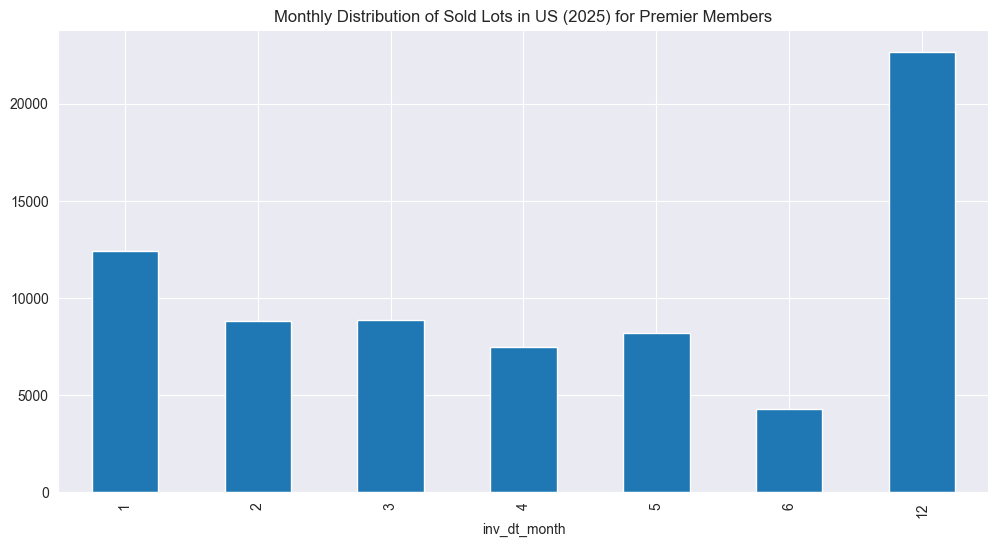

In [32]:
data_PMs_bids_lotssold_6months['inv_dt_month'].value_counts().sort_index().plot(kind='bar', figsize=(12, 6), title='Monthly Distribution of Sold Lots in US (2025) for Premier Members')

### Q5. What is the category that Premier members fall into? Dismantler, Dealer etc?

In [3]:
query4 = """
select member_sgmnt_type, count(distinct owner_mbr_nbr) as member_count
from `cprtpr-dataplatform-sp1`.usviews.v_us_member_fact
where mbr_mbrshp_type_cd = 'PREMIER'
group by member_sgmnt_type
"""

data_PM_type = client.query(query4).to_dataframe()

In [4]:
data_PM_type

,member_sgmnt_type,member_count
0,Exporter,21541
1,General Business,3640
2,None,4125
3,Consumer,45356
4,Dismantler,6491
5,Dealer,23202


### Q6. Where are the Premier members located? Top 10 countries and volume(lots sold) in the last 6 months

In [6]:
query5 = """
select mbr_country_desc, count(distinct owner_mbr_nbr) as member_count, count(distinct lot_nbr) as lots_bought
from `cprtpr-dataplatform-sp1`.usviews.v_us_member_fact m
join `cprtpr-dataplatform-sp1`.usviews.v_us_lot_fact l
on m.owner_mbr_nbr = l.owner_buyer_nbr
where mbr_mbrshp_type_cd = 'PREMIER' and inv_dt between '2024-12-01' and '2025-05-31'
group by mbr_country_desc
"""

data_PM_country = client.query(query5).to_dataframe()

In [26]:
data_PM_country

,mbr_country_desc,member_count,lots_bought
0,FINLAND,6,35
1,"CONGO, DEMOCRATIC REPUBLIC OF",1,8
2,BAHAMAS,271,2938
3,MEXICO,3541,146623
4,HUNGARY,4,157
...,...,...,...
117,SAINT LUCIA,2,5
118,EL SALVADOR,1001,23510
119,CURACAO,24,522
120,TAJIKISTAN,1,19


### Q7. Find count of members who placed bids on lots sold in the last 6 months but did not buy any lots?

In [145]:
## All PMs currently
query6 = """
select owner_mbr_nbr, mbr_nbr
from `cprtpr-dataplatform-sp1`.usviews.v_us_member_fact
where mbr_mbrshp_type_cd = 'PREMIER'
"""

data_PMs = client.query(query6).to_dataframe()

In [147]:
## All PMs who have won and bought a lot in the last 12 months

query7 = """
select m.owner_mbr_nbr, m.mbr_nbr
from `cprtpr-dataplatform-sp1`.usviews.v_us_member_fact m
 join `cprtpr-dataplatform-sp1`.usviews.v_us_lot_fact l
on m.mbr_nbr  = l.buyer_nbr
where (inv_dt between '2024-06-01' AND '2025-05-31' and
      m.mbr_mbrshp_type_cd = 'PREMIER')
"""

data_PMs_lot_won_6_months = client.query(query7).to_dataframe()

In [150]:
## Count unique PMs :

print("Count of unique PMs ", data_PMs['owner_mbr_nbr'].nunique())
print("Count of unique PMs who have won and bought ", data_PMs_lot_won_6_months['owner_mbr_nbr'].nunique())
print("Count of unique who did not win ", data_PMs['owner_mbr_nbr'].nunique() - data_PMs_lot_won_6_months['owner_mbr_nbr'].nunique())

Count of unique PMs  104111
Count of unique PMs who have won and bought  64682
Count of unique who did not win  39429


In [151]:
all_pms = set(data_PMs['mbr_nbr'].unique())
won_pms = set(data_PMs_lot_won_6_months['mbr_nbr'].unique())

lst_PMs_who_bid_but_did_not_win = list(all_pms - won_pms)

In [152]:
lst_PMs_who_bid_but_did_not_win

[np.int64(917504),
 np.int64(524289),
 np.int64(786434),
 np.int64(1),
 np.int64(131073),
 np.int64(262149),
 np.int64(6),
 np.int64(393223),
 np.int64(131080),
 np.int64(393225),
 np.int64(131079),
 np.int64(917515),
 np.int64(524300),
 np.int64(655372),
 np.int64(131085),
 np.int64(15),
 np.int64(262160),
 np.int64(786451),
 np.int64(131091),
 np.int64(393238),
 np.int64(262167),
 np.int64(524311),
 np.int64(131097),
 np.int64(524314),
 np.int64(131099),
 np.int64(393247),
 np.int64(262188),
 np.int64(131118),
 np.int64(260525),
 np.int64(131121),
 np.int64(786482),
 np.int64(524339),
 np.int64(655410),
 np.int64(917553),
 np.int64(131124),
 np.int64(393271),
 np.int64(131128),
 np.int64(655417),
 np.int64(524346),
 np.int64(131129),
 np.int64(131131),
 np.int64(524349),
 np.int64(917565),
 np.int64(755507),
 np.int64(131136),
 np.int64(655425),
 np.int64(131137),
 np.int64(131138),
 np.int64(70),
 np.int64(131143),
 np.int64(262217),
 np.int64(917582),
 np.int64(79),
 np.int64(65543

In [153]:
## Converting the list of PMs who bid but did not win to integers for querying in BigQuery

lst_PMs_clean = [int(x) for x in lst_PMs_who_bid_but_did_not_win]

ids_str = ",".join(str(x) for x in lst_PMs_clean)

In [156]:
## All PMs who did bid in the last 6 months but did not win

query8 = f"""
select buyer_nbr, lot_nbr
from `cprtpr-dataplatform-sp1`.usviews.v_us_bids_fact
where buyer_nbr in ({ids_str})
"""

data_PMs_bid_did_not_win = client.query(query8).to_dataframe()

In [157]:
data_PMs_bid_did_not_win.head()

,buyer_nbr,lot_nbr
0,748609,39884410
1,748609,39884410
2,356776,39886710
3,394462,39890070
4,394462,39890070


In [158]:
data_PMs_bid_did_not_win['buyer_nbr'].nunique()

37616

### Q8.Find member win %? Definition- # of PMs bought at least 1 lot/(# of PMs who placed at least one bid). Do this month over month over last 12 months for lots sold

In [159]:
query10 = f"""

select buyer_nbr, extract(month from inv_dt) as month, lot_nbr
from `cprtpr-dataplatform-sp1`.usviews.v_us_lot_fact l
join `cprtpr-dataplatform-sp1`.usviews.v_us_member_fact m
on l.buyer_nbr = m.mbr_nbr
where mbr_mbrshp_type_cd = 'PREMIER'
and inv_dt is not null and inv_dt between '2024-06-01' and '2025-05-31'
"""

data_PMs_lots_won_every_month = client.query(query10).to_dataframe()

In [160]:
data_PMs_lots_won_every_month

,buyer_nbr,month,lot_nbr
0,757902,1,80650464
1,580022,1,80166344
2,533134,1,80037324
3,392353,1,80126844
4,927620,1,78981564
...,...,...,...
3401710,303989,12,82575424
3401711,798789,12,82056124
3401712,236555,12,82230874
3401713,453738,12,81900784


In [162]:
query11 = f"""

select lot_nbr, count(distinct buyer_nbr) as total_distinct_buyer_nbr, count(distinct bid_id) as total_bid_id
from `cprtpr-dataplatform-sp1`.usviews.v_us_bids_fact b
join `cprtpr-dataplatform-sp1`.usviews.v_us_member_fact m
on b.buyer_nbr = m.mbr_nbr
where mbr_mbrshp_type_cd = 'PREMIER'
and lot_nbr in (select lot_nbr from `cprtpr-dataplatform-sp1`.usviews.v_us_lot_fact
where inv_dt is not null and inv_dt between '2024-06-01' and '2025-05-31')
group by lot_nbr
"""

data_lots_total_bid = client.query(query11).to_dataframe()

In [163]:
data_lots_total_bid.head()

,lot_nbr,total_distinct_buyer_nbr,total_bid_id
0,61408954,21,94
1,79893374,23,185
2,75036154,67,782
3,50283424,22,128
4,81801424,56,317


In [164]:
abc = pd.merge(data_PMs_lots_won_every_month, data_lots_total_bid, on='lot_nbr', how='inner')
abc

,buyer_nbr,month,lot_nbr,total_distinct_buyer_nbr,total_bid_id
0,757902,1,80650464,11,44
1,580022,1,80166344,11,46
2,533134,1,80037324,9,28
3,392353,1,80126844,8,35
4,927620,1,78981564,13,68
...,...,...,...,...,...
3401696,303989,12,82575424,10,40
3401697,798789,12,82056124,6,20
3401698,236555,12,82230874,4,46
3401699,453738,12,81900784,7,21


In [165]:
abc['win_percentage'] = round((1 / abc['total_distinct_buyer_nbr'])*100,2)

In [166]:
abc

,buyer_nbr,month,lot_nbr,total_distinct_buyer_nbr,total_bid_id,win_percentage
0,757902,1,80650464,11,44,9.09
1,580022,1,80166344,11,46,9.09
2,533134,1,80037324,9,28,11.11
3,392353,1,80126844,8,35,12.5
4,927620,1,78981564,13,68,7.69
...,...,...,...,...,...,...
3401696,303989,12,82575424,10,40,10.0
3401697,798789,12,82056124,6,20,16.67
3401698,236555,12,82230874,4,46,25.0
3401699,453738,12,81900784,7,21,14.29


<Axes: xlabel='month'>

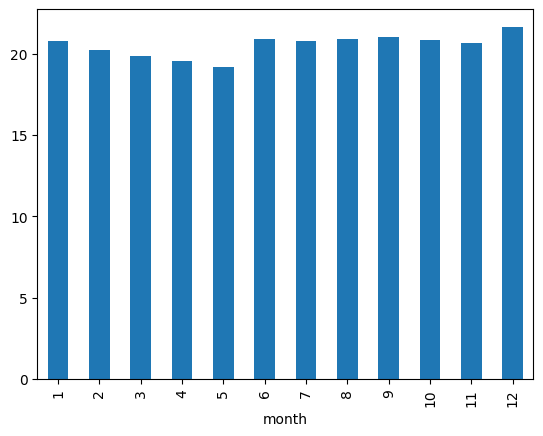

In [167]:
abc.groupby('month')['win_percentage'].mean().plot(kind='bar')

In [168]:
abc.groupby('month')['win_percentage'].mean()

month
1      20.80288
2     20.253505
3     19.847382
4     19.555385
5     19.183165
6     20.891091
7     20.776243
8     20.933471
9      21.01988
10    20.881179
11    20.661622
12    21.658249
Name: win_percentage, dtype: Float64